# DTSA 5011 Introduction To Deep Learning -- Final Project

### <font color=''>Contents<font><a class='anchor' id='top'></a>

[Problem Description](#section-one)  
    
[Data Preparation](#section-two)
    
[EDA Procedure](#section-six)
    
[Analysis & Results - Model Building & Training](#section-three)
    
[Discussion / Conclusion](#section-five)
    
[References](#section-seven) 

<a class="anchor" id="section-one"></a>
## Introduction: Flower Classification w/ Transfer Learning 

Part of the "Getting Started" Kaggle Competition [Petals to the Metal - Flower Classification on TPU](https://www.kaggle.com/competitions/tpu-getting-started/overview/description)

The goal of the project is to classify images of flowers into one of 104 types. Though  there are hundreds of thousands of different kinds of flowers, the dataset is limited to just 104 for simplicity. It's a fairly straightforward multi-class image classification problem. The images themselves are provided in a few different resolutions, but to keep training time resonanble I will use the 224 X 224 RGB images. 

The dataset consists of:
* 12,753 Train set images with known labels
* 3,712 Validation set images to act a s a benchmark during traing


For this project we'll continue to use two features that were an important part of the Week 5 GAN challenge: Use of the optimized TF Record data format and TPU accelerators, which are very useful for accelerating training of computer vision and GAN models. This competition is being billed by Kaggle mainly as a "Getting Started" competition to teach people to use the TPUs properly on their platform and will be a good opportunity to learn how to better use acceleration hardware. 

Because this is a fairly straitforward image classification problem the actual model building will be a little less complicated than a GAN, but will still invlove a few new features we have not used in any assignment to date, particularly Transfer Learning and Data Augmentation to improve validation set accuracy and prevent over-fitting to the training data.


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model

# Download Pre-Trained Resnet Model
from tensorflow.keras.applications import ResNet152V2, VGG16, DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

from kaggle_datasets import KaggleDatasets

%matplotlib inline

Projects like these take far too long without some type of accelerator. So I'm going to get into spirit of this particular competition by enabling TPUs and learning to use them for maximum efficiency. 

In [10]:
# Configure TPU Distributed Compute Strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('TPU Running:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
print("Num Replicas: ", strategy.num_replicas_in_sync)

TPU Running: grpc://10.0.0.2:8470
Num Replicas:  8


In [11]:
# Set parameters for training optimization

# Not a very important hyperparameter for this size data
BUFFER_SIZE = 10000

# TPUs really only work optimally when you have the right batch size
# So we define the batch size in terms of the number of TPU replicas available
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Specify image dimensions for model
IMAGE_SIZE = [224, 224]
HEIGHT = 224
WIDTH = 224

# For optimizing training process
NUM_TRAINING_IMAGES = 12753
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

<a class="anchor" id="section-two"></a>
## Data Preparation

To take advantage of the TPUs and TF Record format we'll need to do a fair amount of setup. First we'll need to set up the directories and labels for the tfrec files. Each set of data (Train and Validation) is stored in 16 tfrec files, though they have different amounts of images stored in each file. 

Once we're set up we'll look at the distribution of classes to see how balanced the data set is. For instance, are some types of flowers much more represented in the data than others?  We'll also look at the diversity of images within classes to see how much diversity there is betweeen images of the same class. Do they all look about the same or are there different angles, views, sizes, etc? 

In [12]:
# This is the path to the TF Record formatted files in the tfrecords-jpeg-224x224 directory
gcs_ds_path = KaggleDatasets().get_gcs_path('tpu-getting-started')
gcs_path = gcs_ds_path + '/tfrecords-jpeg-224x224'

train_loc_tfrec = tf.io.gfile.glob(gcs_path + '/train/*.tfrec')
validation_loc_tfrec = tf.io.gfile.glob(gcs_path + '/val/*.tfrec')
test_loc_tfrec = tf.io.gfile.glob(gcs_path + '/test/*.tfrec')

# Load TFRecord files 
raw_training_dataset = tf.data.TFRecordDataset(train_loc_tfrec)
raw_validation_dataset = tf.data.TFRecordDataset(validation_loc_tfrec)
raw_test_dataset = tf.data.TFRecordDataset(test_loc_tfrec)

print(f'There are approximately {len(train_loc_tfrec)* 798} Train images')
print(f'There are approximately {len(validation_loc_tfrec)* 232} Validation images')

There are approximately 12768 Train images
There are approximately 3712 Validation images
There are approximately 7392 Test images


In [13]:
# Create a dictionary to store the labels
labeled_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
}

unlabeled_feature_description = {
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string)
}

In [14]:
# Fnctions to read and extract images from tfrec-formatted dataset

def _parse_labeled_image_function(proto_image):
    example = tf.io.parse_single_example(proto_image, labeled_feature_description)
    image = tf.io.decode_jpeg(example['image'])
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, IMAGE_SIZE)
    label = tf.cast(example['class'], tf.int32)
    return image, label


In [15]:
# Prepare datasets

# Parse labeled images, shuffle and batch
training_dataset = (
    raw_training_dataset
    .map(_parse_labeled_image_function)
    .repeat()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

validation_dataset = (
    raw_validation_dataset
    .map(_parse_labeled_image_function)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

<a class="anchor" id="section-six"></a>
## EDA Procedure

Now that we're all set up we'll look at the distribution of classes to see how balanced the data set is. For example, are some types of flowers much more represneted than others?  The we'll look at the diversity of images within classes to see how much diversity there is betweeen images of the same class. Do they all look about the same or are there different angles, views, sizes, etc? 

#### Visualize Class Counts For Train/Validation Sets

Here we'll build a pandas dataframe of counts, class labels and names in the train and validation sets for examination. This will allow us to examine the class distribtion and see how imbalanced the 104 classes in the dataset are.

In [68]:
# Create array of just the labels
train_labs = next(iter(training_dataset.unbatch().map(lambda image, label: label).batch(NUM_TRAINING_IMAGES))).numpy()
print(len(train_labs))

validation_labs = next(iter(validation_dataset.unbatch().map(lambda image, label: label).batch(NUM_TRAINING_IMAGES))).numpy()
print(len(validation_labs))

class_names = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 
    'wild geranium', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 
    'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 
    'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 
    'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 
    'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 
    'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 
    'carnation', 'garden phlox', 'love in the mist', 'cosmos',  'alpine sea holly', 
    'ruby-lipped cattleya', 'cape flower', 'great masterwort',  'siam tulip', 
    'lenten rose', 'barberton daisy', 'daffodil',  'sword lily', 'poinsettia', 
    'bolero deep blue',  'wallflower', 'marigold', 'buttercup', 'daisy', 
    'common dandelion', 'petunia', 'wild pansy', 'primula',  'sunflower', 
    'lilac hibiscus', 'bishop of llandaff', 'gaura',  'geranium', 'orange dahlia', 
    'pink-yellow dahlia', 'cautleya spicata',  'japanese anemone', 'black-eyed susan', 
    'silverbush', 'californian poppy',  'osteospermum', 'spring crocus', 'iris', 
    'windflower',  'tree poppy', 'gazania', 'azalea', 'water lily',  'rose', 
    'thorn apple', 'morning glory', 'passion flower',  'lotus', 'toad lily', 
    'anthurium', 'frangipani',  'clematis', 'hibiscus', 'columbine', 'desert-rose', 
    'tree mallow', 'magnolia', 'cyclamen ', 'watercress',  'canna lily', 
    'hippeastrum ', 'bee balm', 'pink quill',  'foxglove', 'bougainvillea', 
    'camellia', 'mallow',  'mexican petunia',  'bromelia', 'blanket flower', 
    'trumpet creeper',  'blackberry lily', 'common tulip', 'wild rose']

train_counts = [(train_labs == index).sum() for index, label in enumerate(class_names)]
train_labels = [index for index, label in enumerate(class_names)]
val_counts = [(validation_labs == index).sum() for index, label in enumerate(class_names)]
val_labels = [index for index, label in enumerate(class_names)]

train_count_df = pd.DataFrame({'index' :train_labels, 'name': class_names, 'count':train_counts})
val_count_df = pd.DataFrame({'index' : val_labels, 'name': class_names, 'count':val_counts})
print(len(train_count_df), len(val_count_df))
train_count_df.head()

12753
3712
104 104


,index,name,count
0,0,pink primrose,263
1,1,hard-leaved pocket orchid,24
2,2,canterbury bells,15
3,3,sweet pea,21
4,4,wild geranium,715


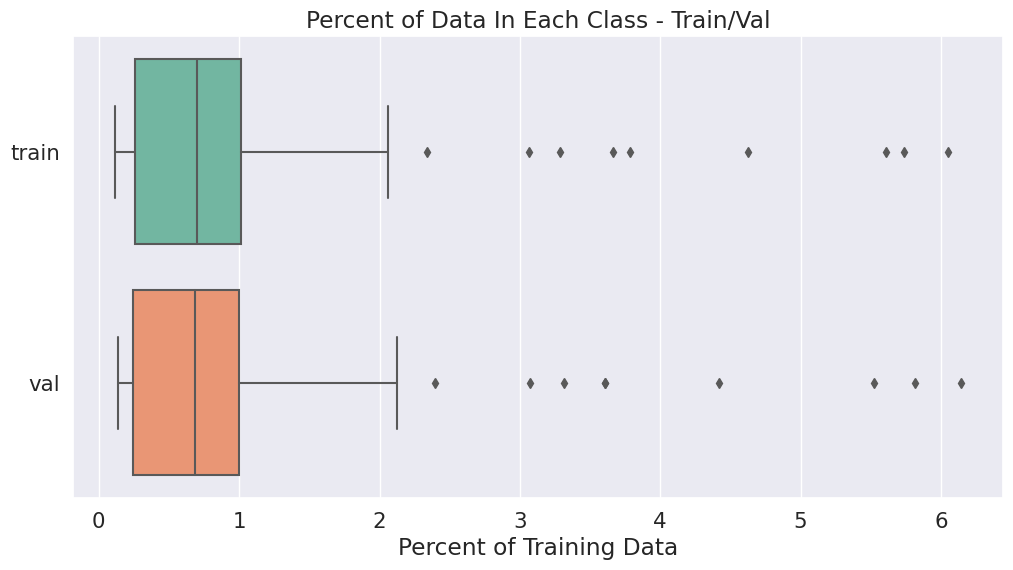

In [69]:
# boxplot of labels intrain / validation datasets
import seaborn as sns

train_count_df['pct'] = (train_count_df['count']/train_count_df['count'].sum())*100
val_count_df['pct'] = (val_count_df['count']/val_count_df['count'].sum())*100

train_count_df['set'] = 'train'
val_count_df['set'] = 'val'

sns.set(font_scale=1.4)

df = pd.concat([train_count_df, val_count_df], axis=0)
plt.figure(figsize=(12,6))
sns.boxplot(x='pct', y='set', data=df, palette = 'Set2')
plt.title('Percent of Data In Each Class - Train/Val')
plt.xlabel('Percent of Training Data')
plt.ylabel('')
plt.show()

The least prevalent class in the train data is fire lily at 0.118% or only 15 examples
The MOST prevalent class in the train data is iris at 6.05% or only 772 examples


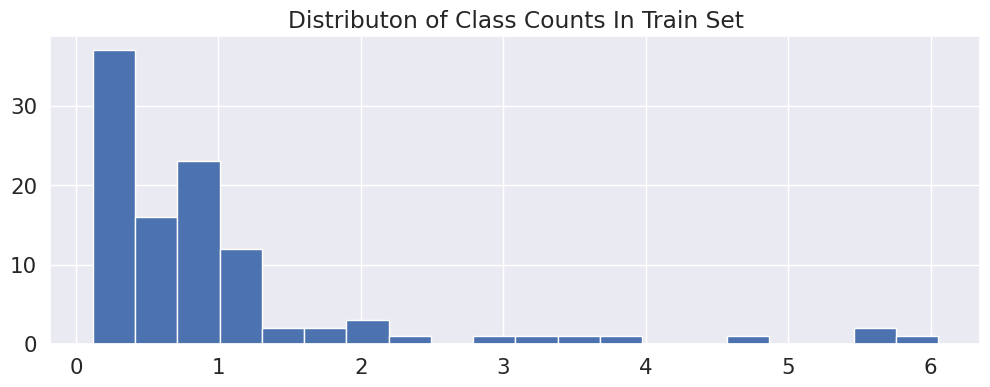

In [70]:
train_count_df = train_count_df.sort_values('count', ascending=True) 
print(f"The least prevalent class in the train data is {train_count_df.iloc[0]['name']} at {train_count_df.iloc[0]['pct']:.3}% or only {train_count_df.iloc[0]['count']} examples")
print(f"The MOST prevalent class in the train data is {train_count_df.iloc[-1]['name']} at {train_count_df.iloc[-1]['pct']:.3}% or only {train_count_df.iloc[-1]['count']} examples")

plt.figure(figsize = (12,4))
plt.hist(df[df['set']=='train']['pct'], bins=20)
plt.title('Distributon of Class Counts In Train Set')
plt.show()

#### Visualize Images

First we'll look at a sample of all the classes to see how diverse the data is within the entire dataset.

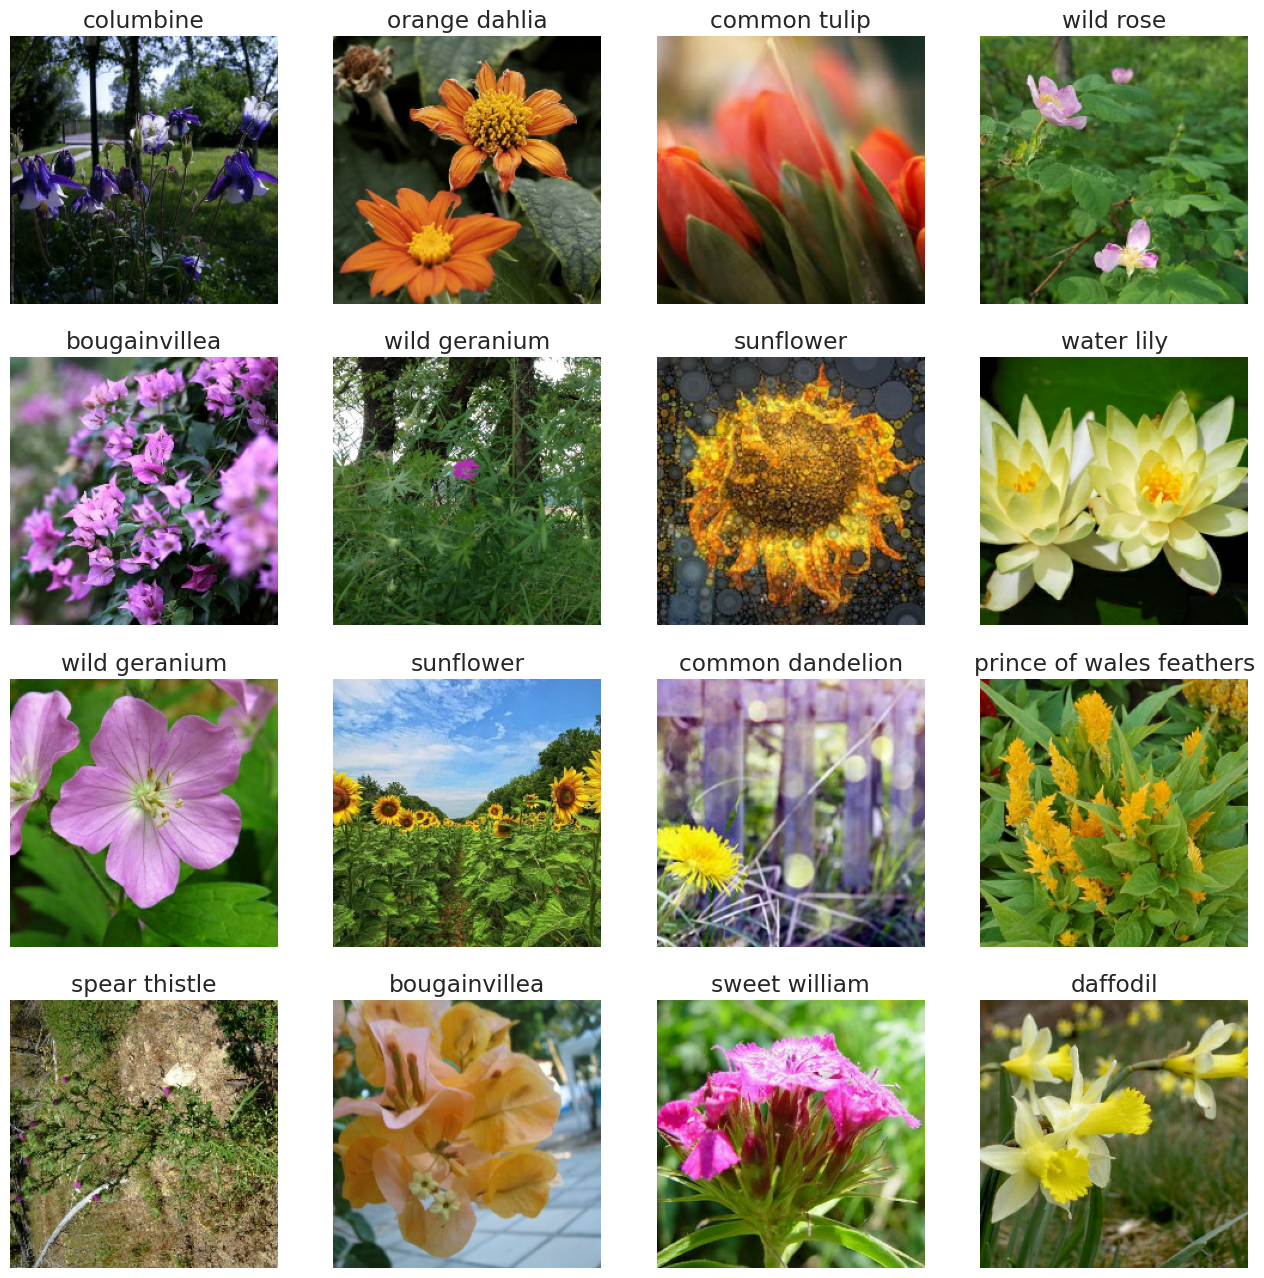

In [71]:
image_batch, label_batch = next(iter(training_dataset))
sns.set_style("whitegrid", {'axes.grid' : False})

plt.figure(figsize = [16, 16])
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(image_batch[i])
    plt.title(class_names[label_batch[i].numpy()])
    plt.axis('off')
    
plt.show()

We can see how diverse the entire dataset is, but how about diversity within classes? 

Here we'll implement a (very slow) function to find and display examples from a particular class.

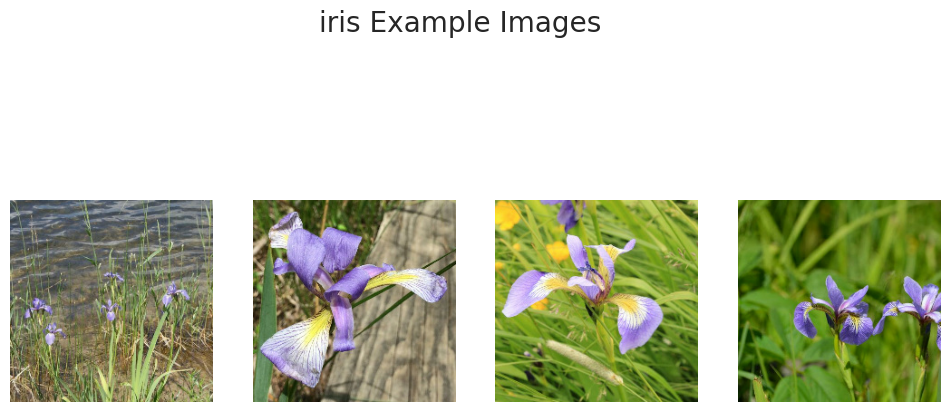

In [73]:
sns.set_style("whitegrid", {'axes.grid' : False})

def show_examples(name, n_examples=4):
    plt.figure(figsize = [12, 6])
    image_batch, label_batch = next(iter(training_dataset))
    example_count = 0
    done = False
    while done == False:
        for i in range(16):
            if class_names[label_batch[i].numpy()] == name:
                example_count += 1
                plt.subplot(1, 4, example_count)
                plt.imshow(image_batch[i])
                plt.axis('off')
        if example_count == n_examples:
            done = True
        else:
            image_batch, label_batch = next(iter(training_dataset))
    plt.suptitle(f"{name} Example Images")
    plt.show()

show_examples('iris')

<a class="anchor" id="section-three"></a>
## Analysis - Model Building and Training

A complex task of this type is ideal for transfer learning from a model with pretrained weights. Pretrained models can be a great way to take features already learned from a much larger dataset and apply them to a similar task. 

The idea behind transfer learning is that all the features learned from the original dataset can be used to learn similar data in a way that is much quicker and more accurate than training an entire model from scratch. A model pre-trained on a large number of diverse images may prove well-suited to this flower classification task. 

A limitation of pretrained models is that if they were trained on a dataset that is very different, even in a non-intuitive way, from the new target data the weights may not transfer properly to the new data, limiting acuracy. 

The Model Building will test three different pre-trained model architectures:

* ResNet152V2: a residual network with 152 layers. Deep networks like this were notoriously difficult to train before the ResNet architecture was first developed. The training is simplified by skip connections that allow the deeper network to learn featues without vanishing gradients.

* VGG16: This is a more conventional CNN architecture that is only 1/8 as deep as the ResNet Model (16 layers). Can classify up to 1000 classes of images. 

* DenseNet201: A variation on the CNN arhitecture that uses long skip connections that allow the model to learn feature representations across many levels of convolutional layers.

These pretrained models can be run with the weights frozen, meaning un-trainable, or a portion of the model unfrozen to do what is called 'fine-tuning'. Fine-tuning the top layers of a network can improve accuracy over the baseline, but care must be taken to avoid overfitting to the training data. For these wodels the learning rate in the fine-tnued layers is set to 0.0001 to try and get ahead of overfitting.

As a first pass we will first obtain baseline results for each model by testing a few different variations of each model:
* Adjusting number of epochs
* Experimenting with unfreezing the top layers
* Adding dropout regularization to prevent overfitting
* Adjusting the learning rate if necessary. 

Our metric for evaluation during training will be **sparse_categorical_accuracy** on the validation set, an accuracy meric that is optimized for sparse categories. We can plot the training / validation sparse_categorical_accuracy to look for evidence of overfitting. We're not interested in the highest accuracy so much as the highest accuracy from where the train / validation curves start to significantly diverge - a telltale sign of ovefitting. 

Once we have baseline "best model" results for each model we can try to understand why they perform poorly/well on this particular data set and select the best performing model in terms of sparse_categorical_accuracy.

Once we select the  most promissing model for this task we will further develop it by adding data augmentation to the training pipeline. 

### ResNet152 Training

Inititally training the resnet had low accuracy and appeared to overfit to the training data after only two epochs. Unfreezing the top layers led to an increase in accuracy with only a slight increase in training time, but also introduced clear overfitting to the training data, with train set accuracy approaching 100% after 10 epochs of training. Increasing the dropout to 0.4 helped with this a little, but not much.

Best model version: 

**0.4 Dropout, 0.001 Learning Rate, Fine tune on top 20 layers**

**0.7592 Validation accuracy after 3 epochs**

In [35]:
inputs = Input(shape=(HEIGHT, WIDTH, 3))

def build_resnet_model():
    inputs = Input(shape=(HEIGHT, WIDTH, 3))
    model = ResNet152V2(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top for new data
    x = GlobalAveragePooling2D()(model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    # softmax to handle the 104-class output
    outputs = Dense(104, activation="softmax")(x)

    # Compile
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["sparse_categorical_accuracy"])
    
    return model

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["sparse_categorical_accuracy"])

# Within scope of TPU distributed compute strategy
with strategy.scope():
    model = build_resnet_model()
    unfreeze_model(model)

history = model.fit(training_dataset, 
                 epochs=10, 
                 validation_data = validation_dataset, 
                 steps_per_epoch = STEPS_PER_EPOCH)

Epoch 1/10
99/99 [==============================] - 57s 256ms/step - loss: 3.2170 - sparse_categorical_accuracy: 0.3239 - val_loss: 2.2391 - val_sparse_categorical_accuracy: 0.4938
Epoch 2/10
99/99 [==============================] - 9s 92ms/step - loss: 1.4662 - sparse_categorical_accuracy: 0.6372 - val_loss: 1.2411 - val_sparse_categorical_accuracy: 0.6894
Epoch 3/10
99/99 [==============================] - 9s 93ms/step - loss: 0.9369 - sparse_categorical_accuracy: 0.7602 - val_loss: 1.0340 - val_sparse_categorical_accuracy: 0.7527
Epoch 4/10
99/99 [==============================] - 9s 94ms/step - loss: 0.6417 - sparse_categorical_accuracy: 0.8311 - val_loss: 0.9286 - val_sparse_categorical_accuracy: 0.7648
Epoch 5/10
99/99 [==============================] - 10s 96ms/step - loss: 0.4115 - sparse_categorical_accuracy: 0.8963 - val_loss: 0.8500 - val_sparse_categorical_accuracy: 0.7896
Epoch 6/10
99/99 [==============================] - 9s 94ms/step - loss: 0.2676 - sparse_categorical_a

Best Val Acc: 0.821


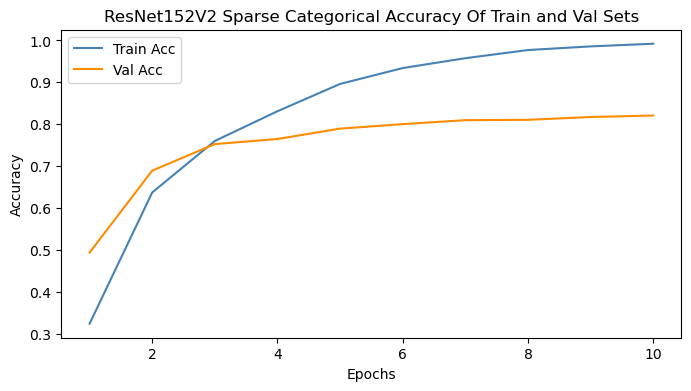

In [38]:
plt.figure(figsize=(8,4))
plt.title(f'ResNet152V2 Sparse Categorical Accuracy Of Train and Val Sets')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

print(f"Best Val Acc: {max(history.history['val_sparse_categorical_accuracy']):.3}")
    
plt.plot(range(1, len(history.history['sparse_categorical_accuracy']) + 1), history.history['sparse_categorical_accuracy'], 'steelblue');
plt.plot(range(1, len(history.history['val_sparse_categorical_accuracy']) + 1), history.history['val_sparse_categorical_accuracy'], 'darkorange')
plt.legend(['Train Acc', 'Val Acc'])
plt.show()

### VGG16 Training

Training at ten epochs produced low accuracy, but no evidence of overfitting, so I increased the epochs to 20 to see if it could keep learning. Unfreezing the top 3 or 5 layers of the model reduced accuracy and introduced problems with overfitting. This is likely because VGG is much shallower network than the other two architectures, with only 16 total layers. 

Best model version: 

**0.25 Dropout, 0.001 Learning Rate**

**0.7026 Val Accuracy after 17 epochs**


In [44]:
inputs = Input(shape=(HEIGHT, WIDTH, 3))

def build_VGG_model():
    inputs = Input(shape=(HEIGHT, WIDTH, 3))
    model = VGG16(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = GlobalAveragePooling2D()(model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    outputs = Dense(104, activation="softmax")(x)

    # Compile
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["sparse_categorical_accuracy"])
    
    return model

def unfreeze_model(model):
    for layer in model.layers[-3:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["sparse_categorical_accuracy"])

with strategy.scope():
    model = build_VGG_model()
    #unfreeze_model(model)

history = model.fit(training_dataset, 
                 epochs=20, 
                 validation_data = validation_dataset, 
                 steps_per_epoch = STEPS_PER_EPOCH)

Epoch 1/20
99/99 [==============================] - 26s 151ms/step - loss: 3.5815 - sparse_categorical_accuracy: 0.2085 - val_loss: 3.8099 - val_sparse_categorical_accuracy: 0.2214
Epoch 2/20
99/99 [==============================] - 8s 78ms/step - loss: 2.3490 - sparse_categorical_accuracy: 0.4304 - val_loss: 3.1054 - val_sparse_categorical_accuracy: 0.3400
Epoch 3/20
99/99 [==============================] - 8s 79ms/step - loss: 1.9358 - sparse_categorical_accuracy: 0.5143 - val_loss: 2.4749 - val_sparse_categorical_accuracy: 0.4685
Epoch 4/20
99/99 [==============================] - 8s 76ms/step - loss: 1.7058 - sparse_categorical_accuracy: 0.5705 - val_loss: 1.9600 - val_sparse_categorical_accuracy: 0.5660
Epoch 5/20
99/99 [==============================] - 8s 78ms/step - loss: 1.5544 - sparse_categorical_accuracy: 0.6054 - val_loss: 1.6291 - val_sparse_categorical_accuracy: 0.6234
Epoch 6/20
99/99 [==============================] - 8s 77ms/step - loss: 1.4215 - sparse_categorical_ac

Best Val Acc: 0.705


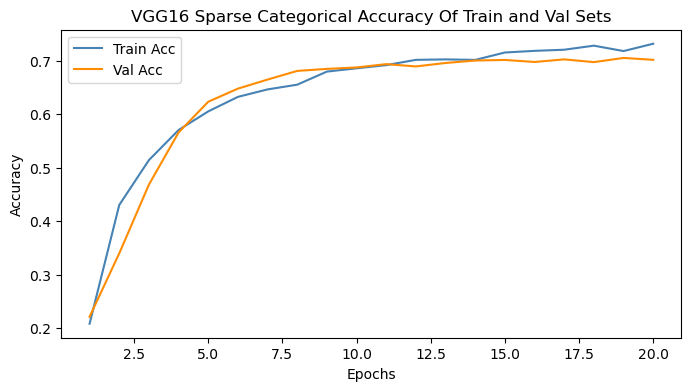

In [45]:
plt.figure(figsize=(8,4))
plt.title(f'VGG16 Sparse Categorical Accuracy Of Train and Val Sets')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

print(f"Best Val Acc: {max(history.history['val_sparse_categorical_accuracy']):.3}")
    
plt.plot(range(1, len(history.history['sparse_categorical_accuracy']) + 1), history.history['sparse_categorical_accuracy'], 'steelblue');
plt.plot(range(1, len(history.history['val_sparse_categorical_accuracy']) + 1), history.history['val_sparse_categorical_accuracy'], 'darkorange')
plt.legend(['Train Acc', 'Val Acc'])
plt.show()

### DenseNet152 Training

Initially got very promissing results that were enhanced by unfreezing the top 20 layers of network. Overfitting only started to become a problem after about 12 epochs with a lerning rate of 0.001. 

Note: Of the two graphs below the top one is with unfrozen weights, while the bottom one is what training/validation accuracy looked like without fine-tuning the top layers of the network. You can clearly see the difference in how each model responded to training across epochs.

Best model version: 

**0.25 Dropout, 0.001 Learning Rate, Unfreezed Top 20 Layers**

**0.8427 Val Accuracy after 12 epochs**

In [50]:
inputs = Input(shape=(HEIGHT, WIDTH, 3))

def build_densenet_model():
    inputs = Input(shape=(HEIGHT, WIDTH, 3))
    model = DenseNet201(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = GlobalAveragePooling2D()(model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    outputs = Dense(104, activation="softmax")(x)

    # Compile
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["sparse_categorical_accuracy"])
    
    return model

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["sparse_categorical_accuracy"])

with strategy.scope():
    model = build_model()
    unfreeze_model(model)
    
history = model.fit(training_dataset, 
                 epochs=20, 
                 validation_data = validation_dataset, 
                 steps_per_epoch = STEPS_PER_EPOCH)

Epoch 1/20
99/99 [==============================] - 81s 378ms/step - loss: 4.2161 - sparse_categorical_accuracy: 0.1223 - val_loss: 3.2380 - val_sparse_categorical_accuracy: 0.3376
Epoch 2/20
99/99 [==============================] - 11s 116ms/step - loss: 2.9056 - sparse_categorical_accuracy: 0.3780 - val_loss: 2.4314 - val_sparse_categorical_accuracy: 0.4987
Epoch 3/20
99/99 [==============================] - 11s 115ms/step - loss: 2.1959 - sparse_categorical_accuracy: 0.5186 - val_loss: 1.9560 - val_sparse_categorical_accuracy: 0.5954
Epoch 4/20
99/99 [==============================] - 11s 112ms/step - loss: 1.7744 - sparse_categorical_accuracy: 0.6050 - val_loss: 1.6298 - val_sparse_categorical_accuracy: 0.6697
Epoch 5/20
99/99 [==============================] - 11s 115ms/step - loss: 1.4870 - sparse_categorical_accuracy: 0.6742 - val_loss: 1.3924 - val_sparse_categorical_accuracy: 0.7228
Epoch 6/20
99/99 [==============================] - 11s 115ms/step - loss: 1.2528 - sparse_cate

Best Val Acc: 0.873


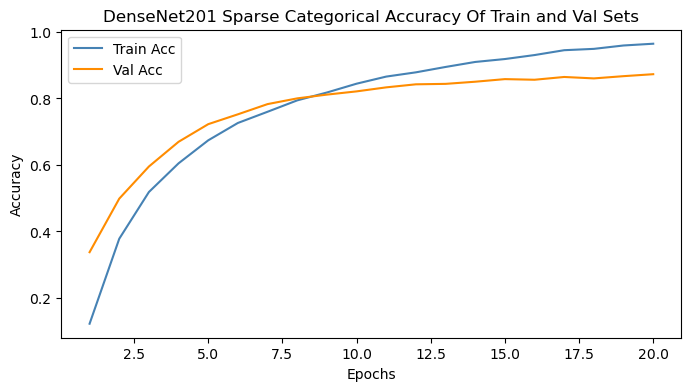

In [51]:
plt.figure(figsize=(8,4))
plt.title(f'DenseNet201 Sparse Categorical Accuracy Of Train and Val Sets')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

print(f"Best Val Acc: {max(history.history['val_sparse_categorical_accuracy']):.3}")
    
plt.plot(range(1, len(history.history['sparse_categorical_accuracy']) + 1), history.history['sparse_categorical_accuracy'], 'steelblue');
plt.plot(range(1, len(history.history['val_sparse_categorical_accuracy']) + 1), history.history['val_sparse_categorical_accuracy'], 'darkorange')
plt.legend(['Train Acc', 'Val Acc'])
plt.show()

Best Val Acc: 0.855


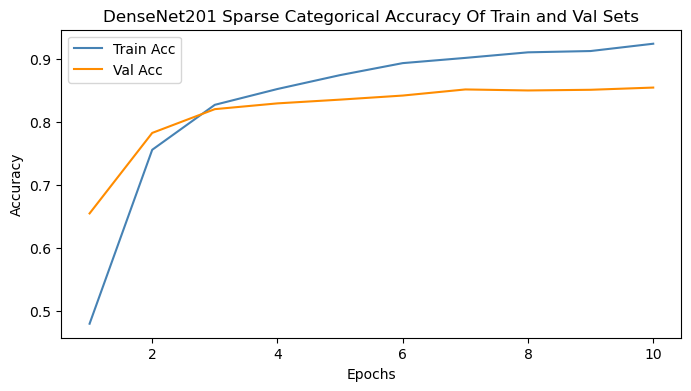

In [47]:
plt.figure(figsize=(8,4))
plt.title(f'DenseNet201 Sparse Categorical Accuracy Of Train and Val Sets')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

print(f"Best Val Acc: {max(history.history['val_sparse_categorical_accuracy']):.3}")
    
plt.plot(range(1, len(history.history['sparse_categorical_accuracy']) + 1), history.history['sparse_categorical_accuracy'], 'steelblue');
plt.plot(range(1, len(history.history['val_sparse_categorical_accuracy']) + 1), history.history['val_sparse_categorical_accuracy'], 'darkorange')
plt.legend(['Train Acc', 'Val Acc'])
plt.show()

### Explore Image Data Augmentation

Augmenting the data involves transforming the images to add more diversity to the training data using existing data. This is a way of adding diversity to existing data, in a way that can help your model generalize better to new data it;s never seen.  

Here we won't do anything too complicated, though there are many types of data augmentation for images that can really improve your model. The augmentations we'll introduce here are:

* Flip images left/right
* Resize/crop with padding
* Transpose
* Random brightness adjustment
* Random Saturation Adjustment

In Tensorflow/Keras we can easily add the augmentations directly into our training pipeline. 

In [83]:
def add_image_augmentation(image, label):
    """
    Add flip, transpose, brightness, contrast and saturation augmentation
    Using tf.image module
    """
    # Image size and orientation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize_with_crop_or_pad(image, HEIGHT+10, WIDTH+10)
    image = tf.image.random_crop(image, size=[*IMAGE_SIZE, 3])
    image = tf.image.transpose(image)  
    
    # Color properties 
    image = tf.image.random_brightness(image, 0.25)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    
    return image, label    

training_dataset_augmented = (
    raw_training_dataset
    .map(_parse_labeled_image_function)
    .map(add_image_augmentation)
    .repeat()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

In [87]:
def build_densenet_model():
    inputs = Input(shape=(224, 224, 3))
    model = DenseNet201(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = GlobalAveragePooling2D()(model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(104, activation="softmax")(x)

    # Compile
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["sparse_categorical_accuracy"])
    
    return model

def unfreeze_model(model):
    #unfreeze top twenty layers
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["sparse_categorical_accuracy"])

with strategy.scope():
    model = build_densenet_model()
    unfreeze_model(model)
    
history = model.fit(training_dataset_augmented, 
                 epochs=20, 
                 validation_data = validation_dataset, 
                 steps_per_epoch = STEPS_PER_EPOCH)

Epoch 1/20
99/99 [==============================] - 113s 517ms/step - loss: 4.5449 - sparse_categorical_accuracy: 0.0755 - val_loss: 3.6074 - val_sparse_categorical_accuracy: 0.2637
Epoch 2/20
99/99 [==============================] - 24s 245ms/step - loss: 3.3209 - sparse_categorical_accuracy: 0.2749 - val_loss: 2.7537 - val_sparse_categorical_accuracy: 0.4423
Epoch 3/20
99/99 [==============================] - 23s 233ms/step - loss: 2.5972 - sparse_categorical_accuracy: 0.4156 - val_loss: 2.2667 - val_sparse_categorical_accuracy: 0.5264
Epoch 4/20
99/99 [==============================] - 22s 222ms/step - loss: 2.1751 - sparse_categorical_accuracy: 0.5028 - val_loss: 1.9296 - val_sparse_categorical_accuracy: 0.5916
Epoch 5/20
99/99 [==============================] - 22s 229ms/step - loss: 1.8730 - sparse_categorical_accuracy: 0.5635 - val_loss: 1.6826 - val_sparse_categorical_accuracy: 0.6406
Epoch 6/20
99/99 [==============================] - 22s 229ms/step - loss: 1.6460 - sparse_cat

Best Val Acc: 0.828


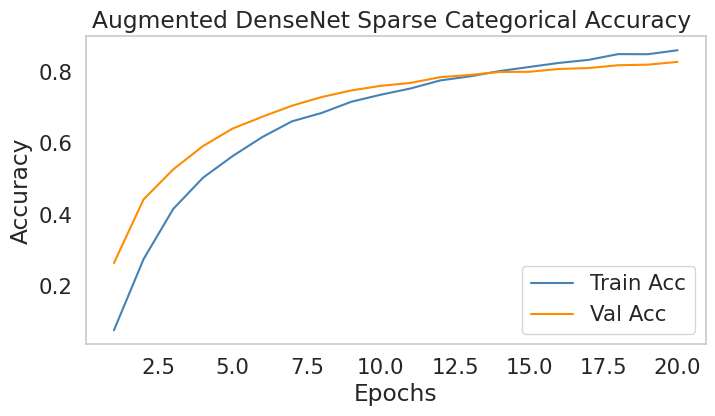

In [88]:
plt.figure(figsize=(8,4))
plt.title(f'Augmented DenseNet Sparse Categorical Accuracy ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

print(f"Best Val Acc: {max(history.history['val_sparse_categorical_accuracy']):.3}")
    
plt.plot(range(1, len(history.history['sparse_categorical_accuracy']) + 1), history.history['sparse_categorical_accuracy'], 'steelblue');
plt.plot(range(1, len(history.history['val_sparse_categorical_accuracy']) + 1), history.history['val_sparse_categorical_accuracy'], 'darkorange')
plt.legend(['Train Acc', 'Val Acc'])
plt.show()

Image augmentation actually decreased training accuracy. F

<a class="anchor" id="section-five"></a>
### Conclusions and Discussion

The training data provided posed a few challenges to model building including:
* imbalanced classes where some classes were much more prevalent / rare than others
* the images of the flowers varied widely both between and within classes, some classes more than others
* training set was a decent size (12k images) but would have to be much bigger to accurately classify a lot of these flowers.

The DenseNet model performed the best out of the three model architectures tested. Fine-tuning the top 20 layers of the pre-trained model increased validation accuracy and was able to prevent overfitting for more epochs.

Data augmentation, at least in the simple way I implemented it, did not improve model accuracy. In fact the model trained on augmented data performed worse than the un-augmented baseline. I suspect this may have been due to the issues with the training data described above, and that adding the data augmentation made these issues even more pronounced. 

Ideas for further improvement include:

* Better data augmentation strategies - I just scratched the surface of what is possible for augmenting the image data in this project. Better, more complex augmentation strategies, possibly in combination with changes to the other parameters, could give us better accuracy. 
* Try a few different pre-trained models - There are many more pre-trained models other than the three I tested here that could prove more suitable to this task. 
* More dense layers on top of pre-trained model - building a better "head" on top of the pretrained network could help the pre-trained models adjust to this particular task. Would add further dropout, batch normalization and dense layers.
* Unfreeze more/fewer levels of pre-trained model - Fine-tuning the pre-trained models at different levels may continue to improve accuracy for this task.


<a class="anchor" id="section-seven"></a>
### References:

* [How to use TPUs with TensorFlow](https://www.tensorflow.org/guide/tpu)
* [Medium Article on Comparison of CNN Architectures For Transfer Learning](https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803)
* [Data Augmentation in TensorFlow Tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation)
* [Transfer Learning in TensorFlow Tutorial](https://www.tensorflow.org/guide/keras/transfer_learning)